### Import Required Packages

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from dowhy import CausalModel
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import networkx as nx
from pgmpy.estimators import HillClimbSearch, BicScore
import dowhy

### Constant Variables

In [59]:
DATASET_PATH = './Data/dataset.csv'
COLUMNS_TO_DROP = [
    'Timestamp',
    'Affiliations',
    'Platforms Used',
    'Social Media User?'
]

### Data Cleaning

#### Load the dataset

In [60]:
df = pd.read_csv(DATASET_PATH)

#### Rename the columns for data analysis

In [61]:

df.rename(columns={'1. What is your age?': 'Age', '2. Gender': 'Gender', '3. Relationship Status': 'Relationship Status',
                   '4. Occupation Status': 'Occupation',
                   '5. What type of organizations are you affiliated with?': 'Affiliations',
                   '6. Do you use social media?': 'Social Media User?',
                   '7. What social media platforms do you commonly use?': 'Platforms Used',
                   '8. What is the average time you spend on social media every day?': 'Hours Per Day',
                   '9. How often do you find yourself using Social media without a specific purpose?': 'ADHD Q1',
                   '10. How often do you get distracted by Social media when you are busy doing something?': 'ADHD Q2',
                   "11. Do you feel restless if you haven't used Social media in a while?": 'Anxiety Q1',
                   '12. On a scale of 1 to 5, how easily distracted are you?': 'ADHD Q3',
                   '13. On a scale of 1 to 5, how much are you bothered by worries?': 'Anxiety Q2',
                   '14. Do you find it difficult to concentrate on things?': 'ADHD Q4',
                   '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?': 'Self Esteem Q1',
                   '16. Following the previous question, how do you feel about these comparisons, generally speaking?': 'Self Esteem Q2',
                   '17. How often do you look to seek validation from features of social media?': 'Self Esteem Q3',
                   '18. How often do you feel depressed or down?': 'Depression Q1',
                   '19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?': 'Depression Q2',
                   '20. On a scale of 1 to 5, how often do you face issues regarding sleep?': 'Depression Q3'}, inplace=True)
df.drop(COLUMNS_TO_DROP, inplace=True, axis=1)

#### Unify the gender category and convert age type

In [62]:

df.replace('Non-binary', 'Non-Binary', inplace=True)
df.replace('Nonbinary ', 'Non-Binary', inplace=True)
df.replace('NB', 'Non-Binary', inplace=True)
df.replace('Non binary ', 'Non-Binary', inplace=True)

df['Age'] = df['Age'].astype('int64')

#### Calculate ADHD and Depression Score

In [63]:

df.loc[df['Self Esteem Q2'] == 1, 'Self Esteem Q2'] = 5
df.loc[df['Self Esteem Q2'] == 2, 'Self Esteem Q2'] = 4
df.loc[df['Self Esteem Q2'] == 3, 'Self Esteem Q2'] = 3
df.loc[df['Self Esteem Q2'] == 4, 'Self Esteem Q2'] = 2
df.loc[df['Self Esteem Q2'] == 5, 'Self Esteem Q2'] = 1

ADHD = ['ADHD Q1', 'ADHD Q2', 'ADHD Q3', 'ADHD Q4']
df['ADHD Score'] = df[ADHD].sum(axis=1)

Anxiety = ['Anxiety Q1', 'Anxiety Q2']
df['Anxiety Score'] = df[Anxiety].sum(axis=1)

SelfEsteem = ['Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3']
df['Self Esteem Score'] = df[SelfEsteem].sum(axis=1)

Depression = ['Depression Q1', 'Depression Q2', 'Depression Q3']
df['Depression Score'] = df[Depression].sum(axis=1)

Total = ['ADHD Score', 'Anxiety Score',
         'Self Esteem Score', 'Depression Score']
df['Total Score'] = df[Total].sum(axis=1)

# Deleting question columns and timestamp columns as they are no longer used
df.drop(columns=ADHD + Anxiety + SelfEsteem + Depression, inplace=True)

#### Convert usage time into integer

In [64]:

df.loc[df['Hours Per Day'] == 'More than 5 hours', 'Hours Per Day'] = 6
df.loc[df['Hours Per Day'] == 'Between 2 and 3 hours', 'Hours Per Day'] = 2.5
df.loc[df['Hours Per Day'] == 'Between 3 and 4 hours', 'Hours Per Day'] = 3.5
df.loc[df['Hours Per Day'] == 'Between 1 and 2 hours', 'Hours Per Day'] = 1.5
df.loc[df['Hours Per Day'] == 'Between 4 and 5 hours', 'Hours Per Day'] = 4.5
df.loc[df['Hours Per Day'] == 'Less than an Hour', 'Hours Per Day'] = 0.5
df['Hours Per Day'] = df['Hours Per Day'].astype('int64')

# since the person who answered 91 also answered that they are college student, we assumed that this was a typo
df.loc[df['Age'] == 91, 'Age'] = 19

#### Map Categorical Values to Numerical Values

In [65]:
def handle_nominal_data(df: pd.DataFrame, feature: str):
    dummy_df = pd.get_dummies(df[feature], drop_first=True)

    # Convert True/False values in dummy_df to 0/1
    dummy_df = dummy_df.astype('int64')

    # Concatenate dummy variables with original DataFrame
    df = pd.concat([df, dummy_df], axis=1)

    # Drop the original 'Relationship Status' column
    df.drop(columns=[feature], inplace=True)

    return df

In [66]:
df = handle_nominal_data(df, 'Relationship Status')
df = handle_nominal_data(df, 'Occupation')
df = handle_nominal_data(df, 'Gender')

### Final Dataset

In [67]:
df.head()

,Age,Hours Per Day,ADHD Score,Anxiety Score,Self Esteem Score,Depression Score,Total Score,In a relationship,Married,Single,Salaried Worker,School Student,University Student,Male,Non-Binary,There are others???,Trans,unsure
0,21,2,18,4,7,14,43,1,0,0,0,0,1,1,0,0,0,0
1,21,6,15,7,7,14,43,0,0,1,0,0,1,0,0,0,0,0
2,21,3,11,6,7,11,35,0,0,1,0,0,1,0,0,0,0,0
3,21,6,12,6,8,9,35,0,0,1,0,0,1,0,0,0,0,0
4,21,2,17,9,9,9,44,0,0,1,0,0,1,0,0,0,0,0


### Data Exploration

#### Data Distribution

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Hours Per Day'}>,
        <Axes: title={'center': 'ADHD Score'}>,
        <Axes: title={'center': 'Anxiety Score'}>],
       [<Axes: title={'center': 'Self Esteem Score'}>,
        <Axes: title={'center': 'Depression Score'}>,
        <Axes: title={'center': 'Total Score'}>,
        <Axes: title={'center': 'In a relationship'}>],
       [<Axes: title={'center': 'Married'}>,
        <Axes: title={'center': 'Single'}>,
        <Axes: title={'center': 'Salaried Worker'}>,
        <Axes: title={'center': 'School Student'}>],
       [<Axes: title={'center': 'University Student'}>,
        <Axes: title={'center': 'Male'}>,
        <Axes: title={'center': 'Non-Binary'}>,
        <Axes: title={'center': 'There are others???'}>],
       [<Axes: title={'center': 'Trans'}>,
        <Axes: title={'center': 'unsure '}>, <Axes: >, <Axes: >]],
      dtype=object)

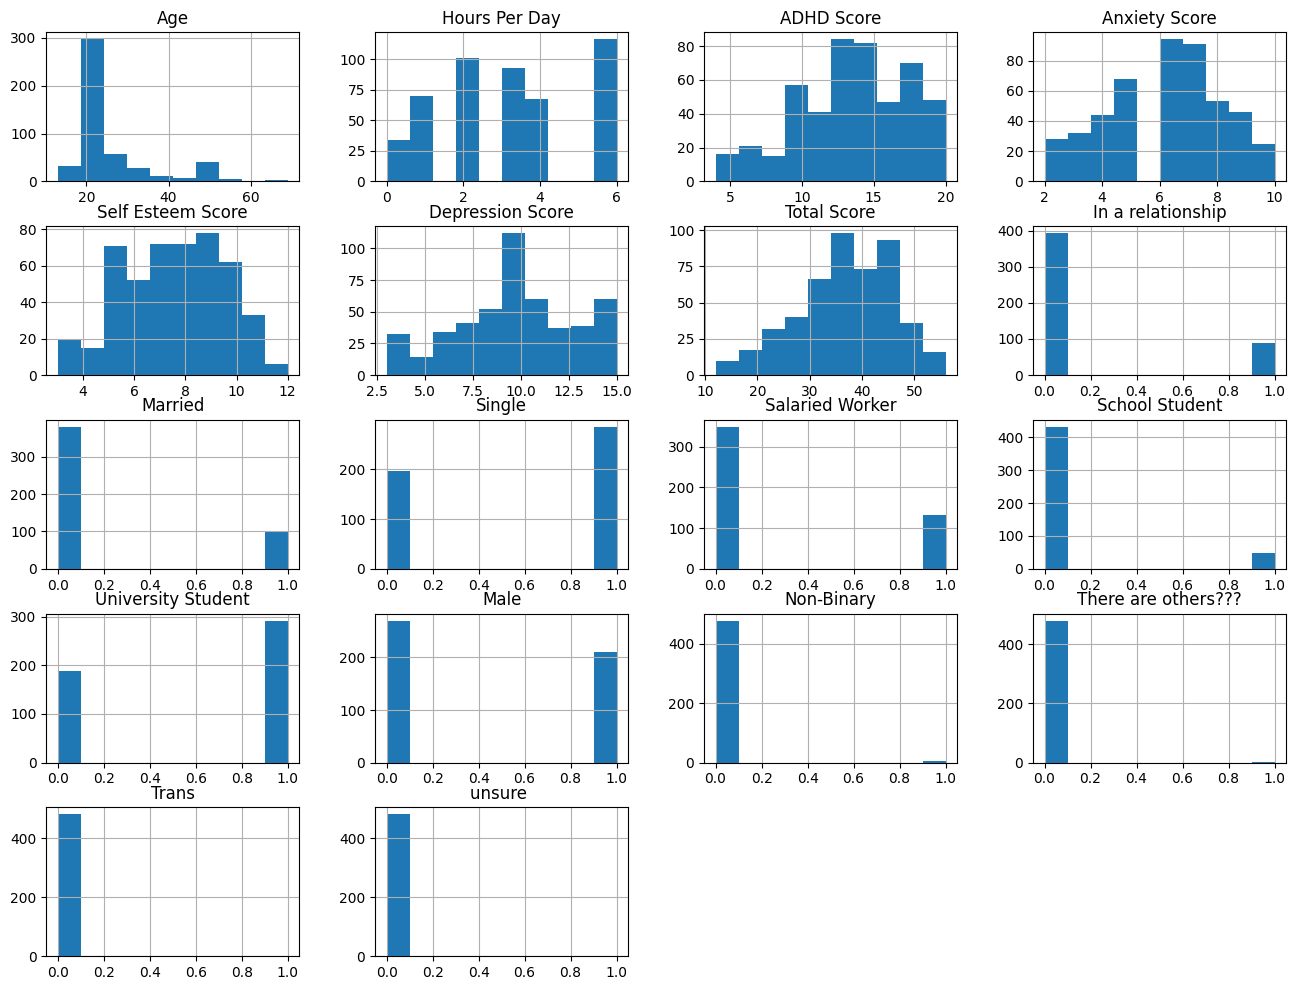

In [68]:
df.hist(figsize=(16, 12))

In [69]:
def generate_heatmap(df: pd.DataFrame):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=ax)
    plt.title('Heat map of how each feature is correlated to each other')

    plt.show()

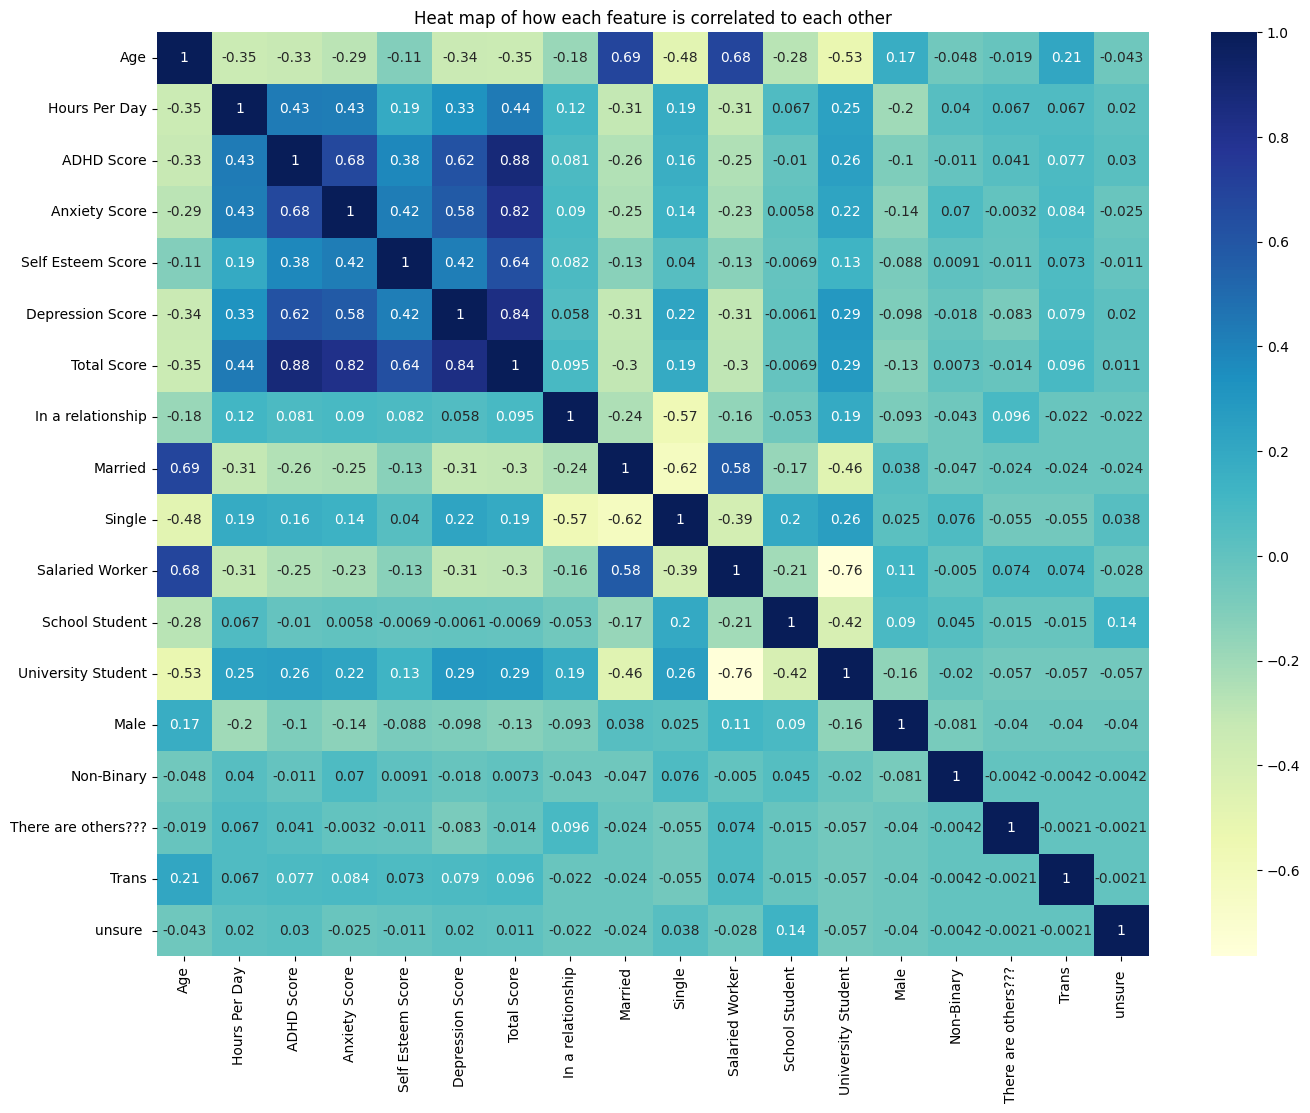

In [70]:
generate_heatmap(df=df)

* After examining the heatmap, we noticed that relationship status and gender do not correlate with other features that are directly or indirectly influencing the social media addiction. Therefore, we have decided to exclude these feature from the dataset to better implement our model for the prediction. (Feature Selection).

In [71]:
df.drop(columns=['Male', 'Non-Binary',
        'There are others???', 'Trans', 'unsure '], inplace=True)
df.head()

,Age,Hours Per Day,ADHD Score,Anxiety Score,Self Esteem Score,Depression Score,Total Score,In a relationship,Married,Single,Salaried Worker,School Student,University Student
0,21,2,18,4,7,14,43,1,0,0,0,0,1
1,21,6,15,7,7,14,43,0,0,1,0,0,1
2,21,3,11,6,7,11,35,0,0,1,0,0,1
3,21,6,12,6,8,9,35,0,0,1,0,0,1
4,21,2,17,9,9,9,44,0,0,1,0,0,1


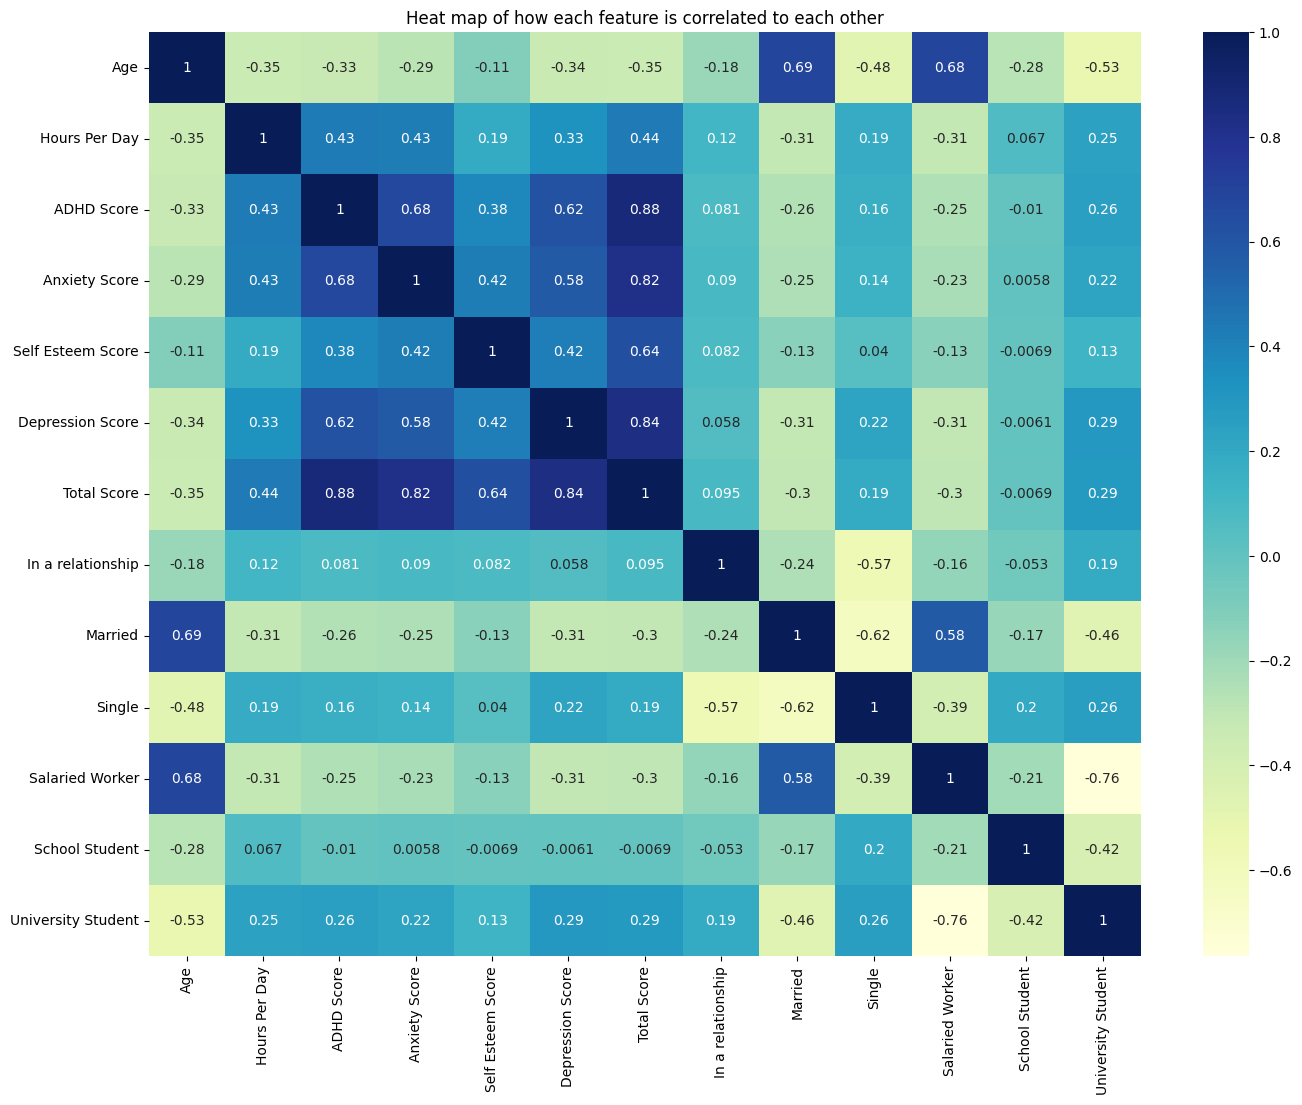

In [72]:
generate_heatmap(df=df)

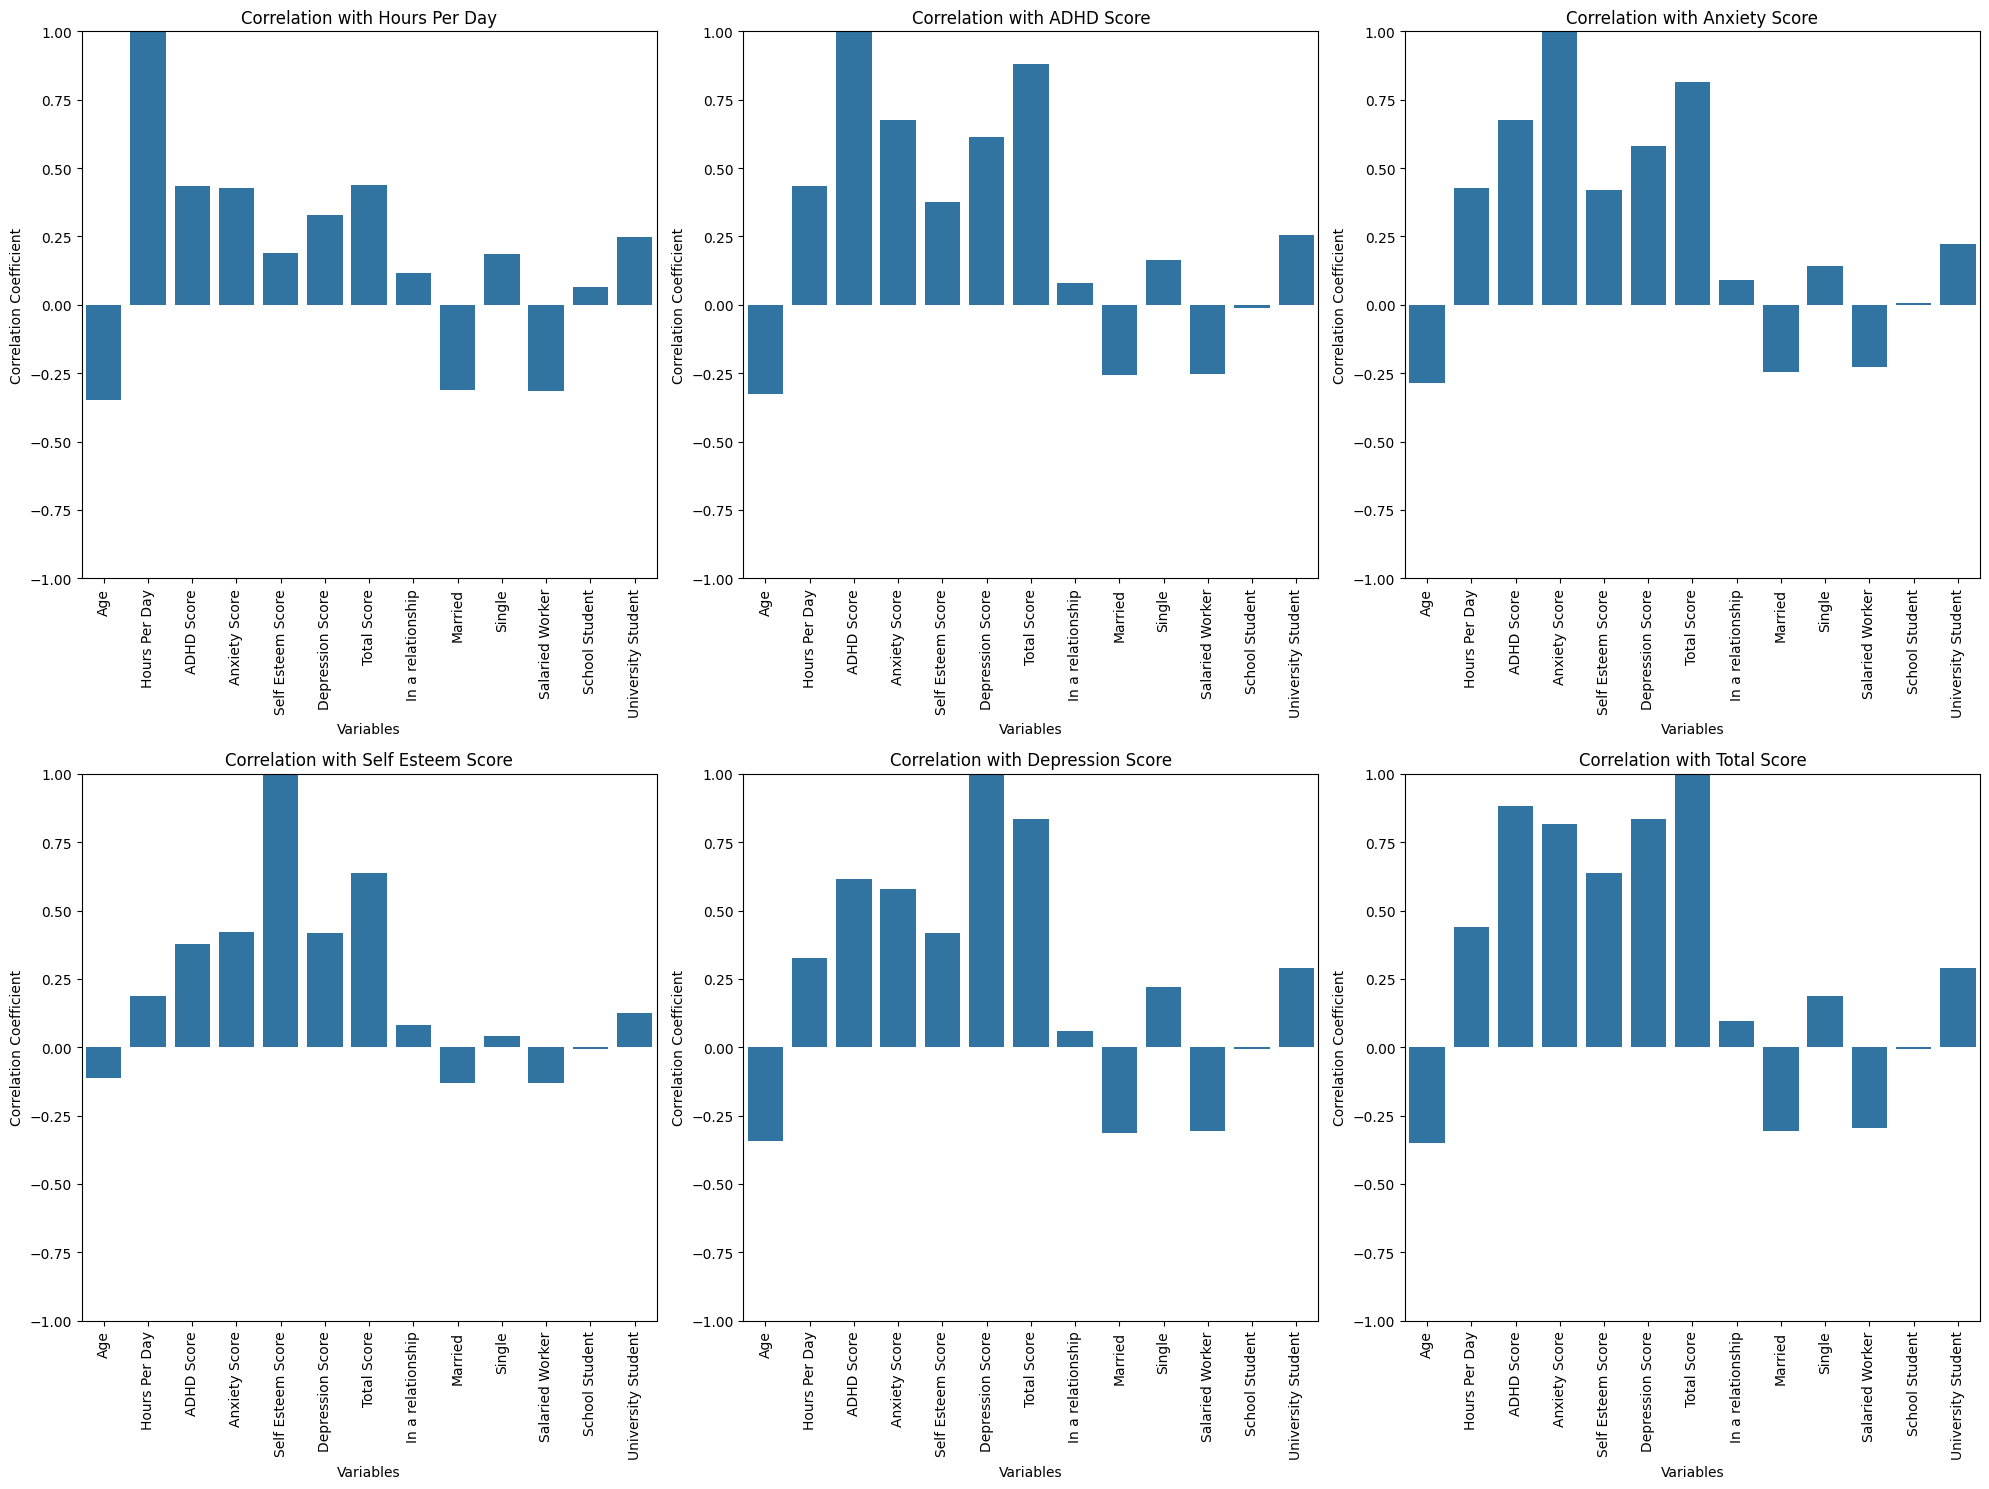

In [73]:
# List of variables to analyze
variables = ['Hours Per Day', 'ADHD Score', 'Anxiety Score',
             'Self Esteem Score', 'Depression Score', 'Total Score']

# Calculate correlation for each variable
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
for i, variable in enumerate(variables):
    corr = df.corr()[variable]

    # Plot correlation
    sns.barplot(x=corr.index, y=corr.values, ax=axes[i//3, i % 3])
    axes[i//3, i % 3].set_title(f'Correlation with {variable}')
    axes[i//3, i % 3].set_xlabel('Variables')
    axes[i//3, i % 3].set_ylabel('Correlation Coefficient')
    axes[i//3, i % 3].tick_params(axis='x', rotation=90)
    axes[i//3, i % 3].set_ylim([-1, 1])

plt.tight_layout()
plt.show()

In [95]:
# Define causal model
model = CausalModel(
    data=df,
    treatment='Hours_Per_Day',
    outcome='Total_Score',
    common_causes=['ADHD_Score', 'Anxiety_Score',
                   'Self_Esteem_Score', 'Depression_Score']
)

# Identify causal effect
identified_estimand = model.identify_effect()

# Estimate causal effect
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

print(estimate)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Hours_Per_Day'] on outcome ['Total_Score']
/Users/nakayamadaiki/.asdf/installs/python/3.11.6/lib/python3.11/site-packages/dowhy/causal_model.py:582: UserWarning: 6 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
ERROR:dowhy.causal_estimator:No valid identified estimand available.


Estimation failed! No relevant identified estimand available for this estimation method.


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 10/1000000 [00:00<21:55:36, 12.67it/s]


Learned Causal Graph Structure:
[('In a relationship', 'Single'), ('Married', 'Single'), ('Married', 'In a relationship'), ('Salaried Worker', 'Married'), ('Salaried Worker', 'Age'), ('Salaried Worker', 'Hours Per Day'), ('School Student', 'Salaried Worker'), ('University Student', 'Salaried Worker'), ('University Student', 'School Student'), ('University Student', 'Depression Score')]


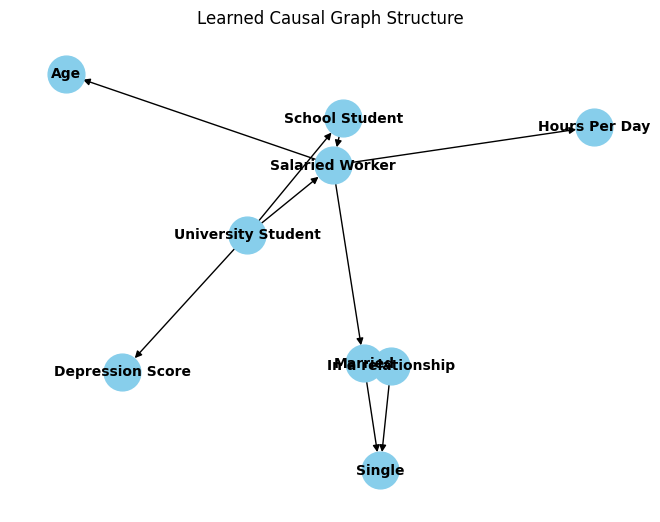

<Figure size 7000x5000 with 0 Axes>

In [94]:
# Instantiate a HillClimbSearch object with the data
hc = HillClimbSearch(df)

# Use Hill climbing to learn the structure of the Bayesian Network
best_model_structure = hc.estimate(scoring_method=BicScore(df))

# Instantiate a BayesianModel with the learned structure
best_model = BayesianModel(best_model_structure.edges())

# Fit the model to the data using Bayesian parameter estimation
best_model.fit(df, estimator=BayesianEstimator)

# Print the learned graph structure
print("Learned Causal Graph Structure:")
print(best_model_structure.edges())

# Create a directed graph
G = nx.DiGraph()

# Add edges from the learned model structure
G.add_edges_from(best_model_structure.edges())

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue",
        font_size=10, font_weight="bold", arrows=True)
plt.title("Learned Causal Graph Structure")
plt.figure(figsize=(70, 50))  # Adjust width and height as needed

# Show plot
plt.show()

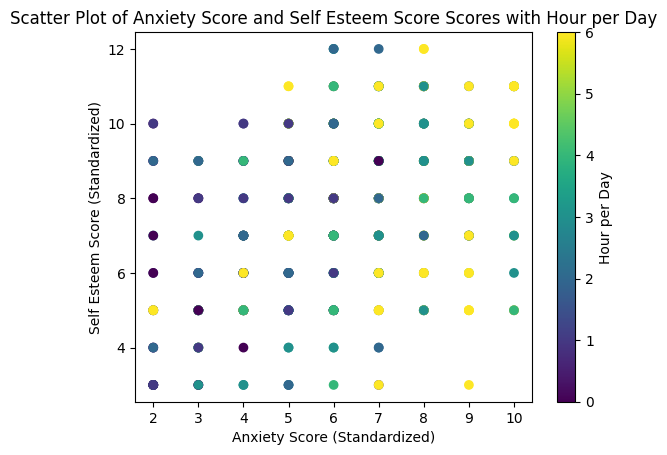

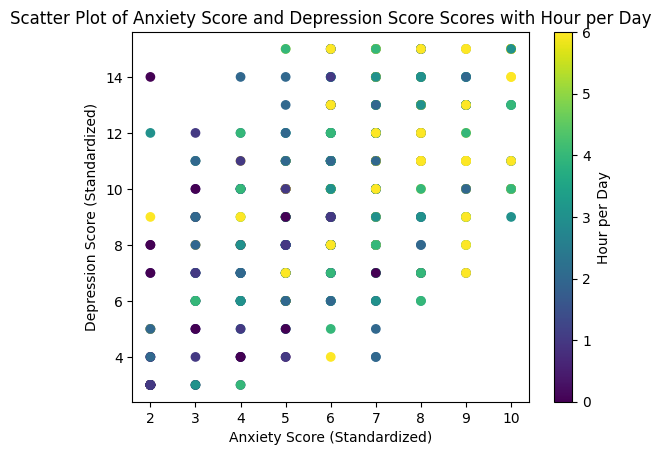

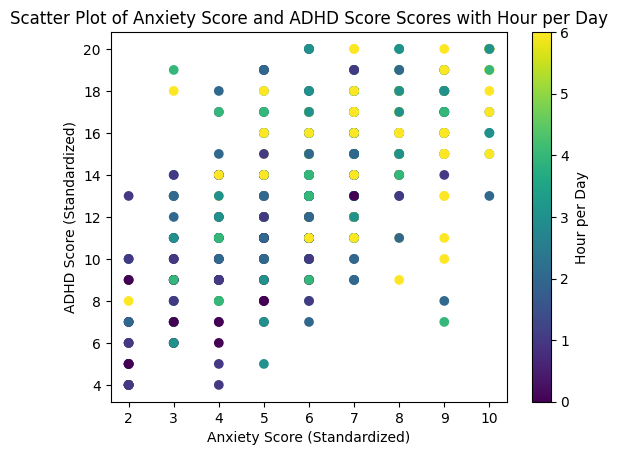

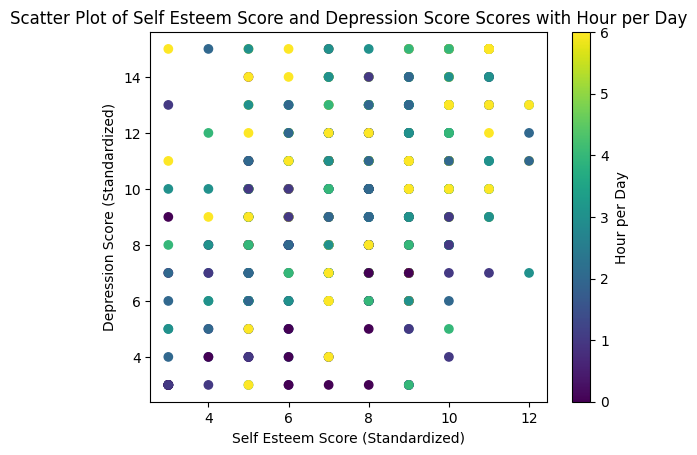

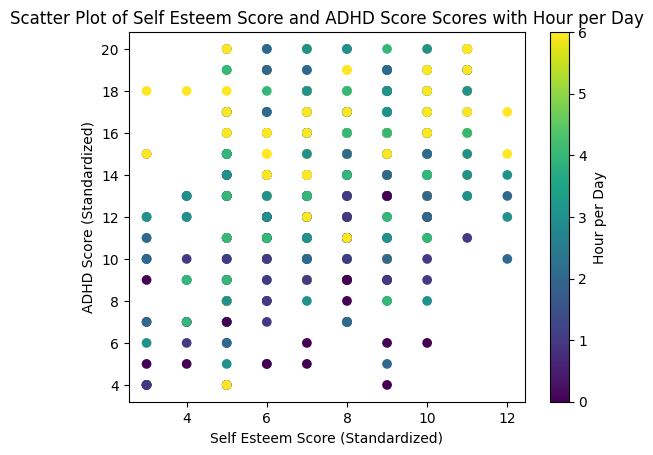

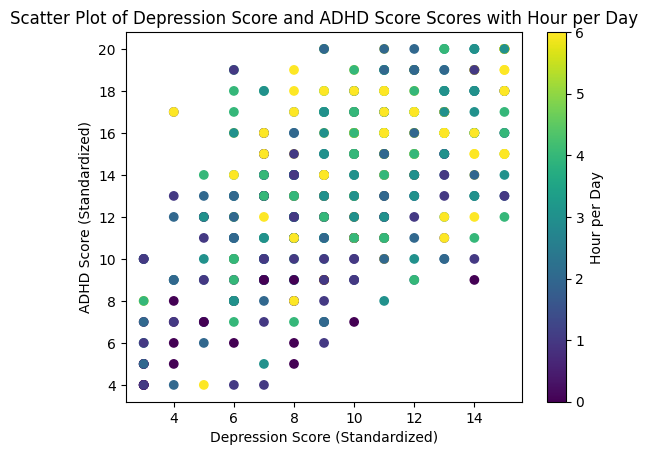

In [80]:

features = ['Anxiety Score', 'Self Esteem Score',
            'Depression Score', 'ADHD Score']

for i in range(len(features)):
    for j in range(i+1, len(features)):
        plt.scatter(df[features[i]], df[features[j]],
                    c=df['Hours Per Day'], cmap='viridis')
        plt.xlabel(f'{features[i]} (Standardized)')
        plt.ylabel(f'{features[j]} (Standardized)')
        plt.title(
            f'Scatter Plot of {features[i]} and {features[j]} Scores with Hour per Day')
        plt.colorbar(label='Hour per Day')
        plt.show()

### Data Preprocessing

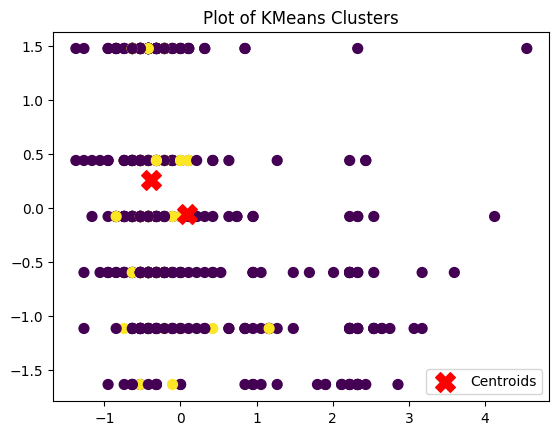

In [76]:
# 1. K-means clustering
standard_scaler = StandardScaler()
df_std = standard_scaler.fit_transform(df)
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(df_std)
y_kmeans = kmeans.labels_  # Predicted cluster labels

plt.scatter(df_std[:, 0], df_std[:,
            1], c=y_kmeans, s=50, cmap='viridis')

# Plot centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[
            :, 1], s=200, c='red', marker='X', label='Centroids')
plt.legend()
plt.title('Plot of KMeans Clusters')
plt.show()

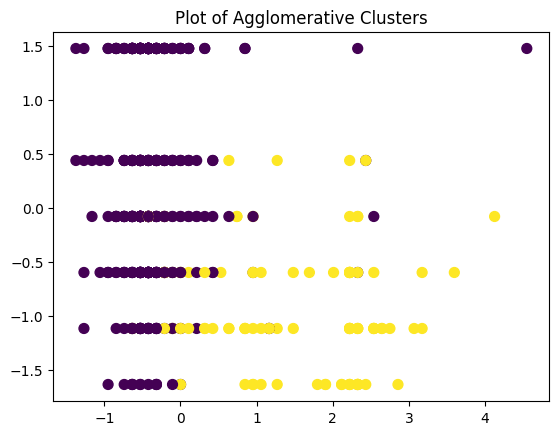

In [77]:
# 2. Agglomerative hierarchical clustering
from sklearn.cluster import AgglomerativeClustering


k_scaled_agglomerative = standard_scaler.fit_transform(df)
agglomerative = AgglomerativeClustering(n_clusters=2)
y_agglomerative = agglomerative.fit_predict(k_scaled_agglomerative)
# Plot centroids of the clusters
plt.scatter(k_scaled_agglomerative[:, 0],
            k_scaled_agglomerative[:, 1], c=y_agglomerative, s=50, cmap='viridis')

plt.title('Plot of Agglomerative Clusters')
plt.show()

        Age  Hours Per Day  ADHD Score  Anxiety Score  Self Esteem Score  \
0 -0.527153      -0.596435    1.164040      -1.031137          -0.245751   
1 -0.527153       1.478685    0.393531       0.409261          -0.245751   
2 -0.527153      -0.077655   -0.633815      -0.070872          -0.245751   
3 -0.527153       1.478685   -0.376978      -0.070872           0.214196   
4 -0.527153      -0.596435    0.907204       1.369526           0.674142   

   Depression Score  Total Score  In a relationship   Married    Single  \
0          1.406422     0.682728            2.11327 -0.515548 -1.205853   
1          1.406422     0.682728           -0.47320 -0.515548  0.829288   
2          0.441388    -0.195032           -0.47320 -0.515548  0.829288   
3         -0.201968    -0.195032           -0.47320 -0.515548  0.829288   
4         -0.201968     0.792448           -0.47320 -0.515548  0.829288   

   Salaried Worker  School Student  University Student  
0        -0.614999       -0.336788 

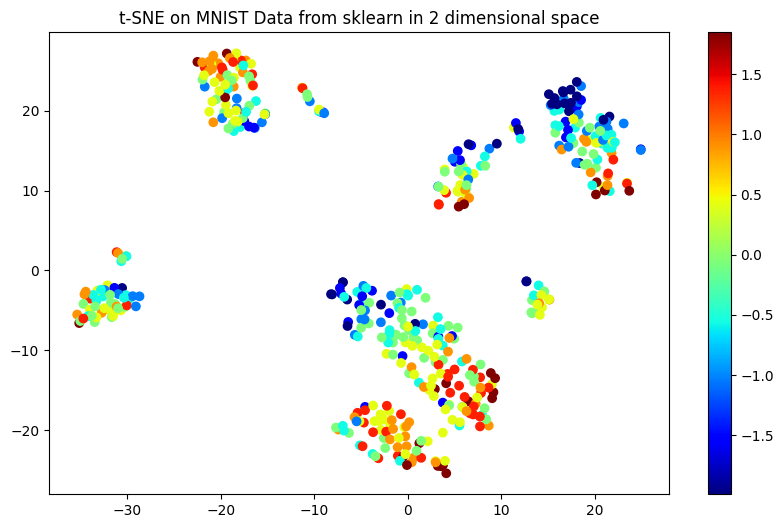

In [79]:

from sklearn.manifold import TSNE

df_scaled = standard_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
print(df_scaled.head())
target_df = df_scaled['Anxiety Score']
social_media_addiction = df_scaled.drop(['Anxiety Score'], axis=1)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(social_media_addiction)

# plotting the result in 2 dimensional space
fig, ax = plt.subplots(figsize=(10, 6))
s = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=target_df, cmap='jet')
ax.set_title("t-SNE on MNIST Data from sklearn in 2 dimensional space")
fig.colorbar(s, ax=ax)
plt.show()